*Go to [https://gist.github.com/illarionovEA/c8f92ded14bde4fcc36940b5dda01ba3](https://gist.github.com/illarionovEA/c8f92ded14bde4fcc36940b5dda01ba3) to view the Notebook with all images*

# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Random number generators

Do you know what actually happens when you call function for generating random numbers, e.g. ```np.random.rand()```?

What is a source of randomness in you computer?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

If we look under the hood of any standard generator we will observe nothing but a **fully deterministic algorithm**. All it can do is to produce a **fully deterministic sequence** of numbers. Anytime, anywhere, at any device you will obtain absolutely the same sequence. That is why they are called pseudorandom number generators.

**Never use standard random generators in cryptographic applications!**

For "true" generators based on natural sources of randomness see e.g. https://www.random.org/.

## Generating of uniform random numbers

You can browse a lot of methods  for generating random numbers [here](https://en.wikipedia.org/wiki/List_of_random_number_generators). We consider the most common one which is a Linear congruential generator (LCG). When you call ```rand()``` in C/C++, you actually call LCG.

Linear congruential generator produces the following sequence:
$$ z_{i+1} = (az_i + c) \mod m $$

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of “random” numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). Obviosuly, this can be easily scaled to any other range $(a,b)$.

Let's implement some LCG:

In [2]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Check the sequence it produces:

In [3]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

One should carefully choose constants $m$, $a$ and $c$. Things can easily go bad if they are choosen "at random":

In [4]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Samples distribution also mimics uniform distribution

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


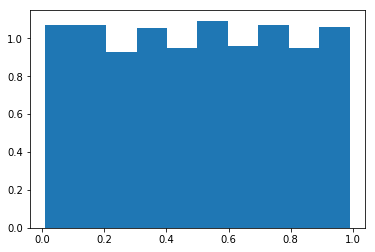

In [5]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

However, spectral test shows that samples are bunched up on five lines

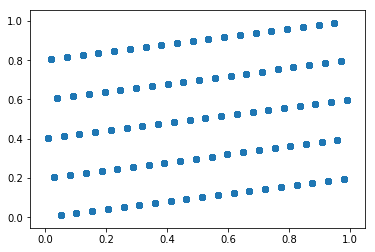

In [6]:
plt.scatter(random[1:], random[:-1])
plt.show()

Appropriate constants produce more "random" scatter

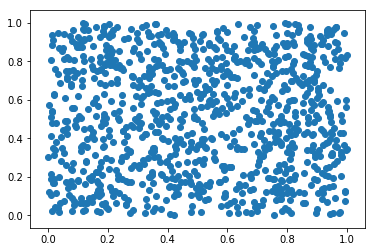

In [7]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

There is a number of tests that check how good random generator works. See [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests) for example.

## Sampling from distributions

Let's suppose we have some generator for uniform random numbers in (0, 1). How we can sample from arbitrary distribution $F$?

### Inverse transform method

Next proposition gives an idea of the *inverse transform method*.

Proove that if $\xi$ is uniform in $[0,1]$ then $F^{-1}(\xi)$ is $F$-distributed. For which $F$ does it hold?



#### Доказательство. 
$\xi:\Omega \rightarrow R$ - случайная величина с распределением $U(0,1)$,  
$X:R \rightarrow R$ - случайная величина с функцией распределения $F$
$F$ строго монотонна, поскольку у неё определена обратная функция. Тогда
$P(F^{-1}(\xi)\leq x)=P(\xi\leq F(x))=F(x)*I_{[0,1]}(x)+I_{[1,+\infty]}(x)$
Значит, $F^{-1}(\xi)$ имеет функцию распределения $F$. Если вместо обратной функции рассмотреть $inf(y: F(y)=x)$, то мы докажем утверждение для произвольной $F$.

### Exercise
Sample 1000 random numbers from $Exp(\lambda)$ distribution using the inverse transform method. Plot the histogram and the true probability density function (PDF).

Input lambda: 5


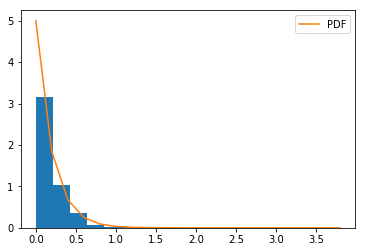

In [8]:
import math
import numpy as np
l = input("Input lambda: ")
l = float(l)
A = np.array([i / 5  for i in range(20)])
numbers = [math.log(1 - rng()) / -l for i in range(1000)]
plt.hist(numbers, density = True)
plt.plot(A, np.array([l * math.exp(-l * A[i]) for i in range(20)]), label = "PDF")
plt.legend()
plt.show()

#### Rejection sampling (Accept-reject method)

Next figure shows an idea:

<img src="https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png" style="width: 50%;"/>

We sample points from proposal PDF (which is known and is easy to sample from) and discard points that are above the target PDF. 

### Exercise
Proove that the accept-reject method is valid. Sample 100 points from truncated cauchy distribution given below using uniform random number generator and the accept-reject method. Plot obtained histogram and the true pdf.

#### Доказательство.
Пусть $(\Omega, F, P)$ - вероятностное пространство, $Y:\Omega \rightarrow R$ и $X:\Omega \rightarrow R$ - случайные величины с плотностью $p(x)$ и $\pi(x)$ и функцией распределения $F(x)$ и $G(x)$ соответственно. Пусть также $U:\Omega \rightarrow R$ - случайная величина, распределённая равномерно на $[0,1]$. Идея состоит в том, что если $Up(Y)$ "равномерно" распределена на своей области под графиком функции $p(x)$ (в кавычках, поскольку равномерное распределение на $R^{2}$ определяют, вообще говоря, на измеримых по мере Лебега множествах), то $Up(Y)I(\{p(Y)\leq\pi(Y)\})$ равномерно заметает график уже функции $\pi(x)$. Это и даёт некую аппроксимацию нужного распределения X.

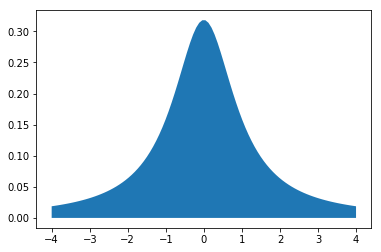

In [10]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

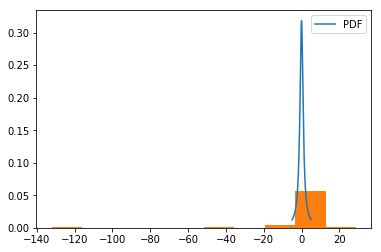

In [11]:
A = np.array([-5 + i / 100 for i in range(1000)])
plt.plot(A, np.array([1/(math.pi*(1 + A[i] * A[i])) for i in range(1000)]), label = "PDF")
B = np.array([rng() * math.tan(math.pi * (rng() - 1 / 2)) for i in range(100)])
plt.hist(B, density = True)
plt.legend()
plt.show()

Accept-reject method allows to sample from any areas and volumes. However, it may be very inefficient. Sometimes it is possible to find coordinate transformation that maps given region to simple one which is easy to sample from (e.g. unit square).

##  Coordinate transformation

### Exercise
Sample 100 point uniformly distributed inside the triangle given below. To do this, find an appropriate transformation from a unit square and sample from it. Check that you have no rejected points. Plot sampled points.

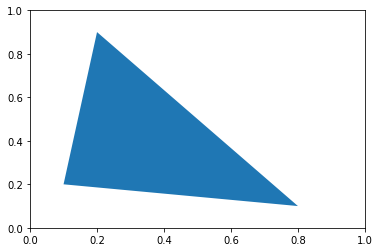

In [12]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

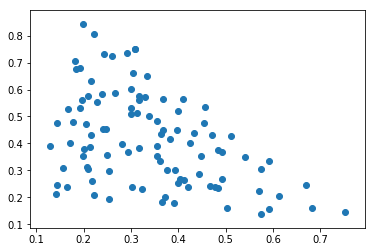

In [13]:
X = np.array([rng() for i in range(100)])
Y = np.array([rng() for i in range(100)])

def reflection(x,y,t):
    if (x + y > 1):
        return [(1 - x) * t,(1 - y) * t]
    return [x * t, y * t]
def movement(a, sin, cos):
    return [cos * a[0] + sin * a[1] + 0.1, sin * a[0] - cos * a[1] + 0.2]

A1 = np.array([reflection(X[i], Y[i], math.sqrt(50) / 10) for i in range(100)])
A2 = np.array([movement(A1[i], 7 / math.sqrt(50), 1 / math.sqrt(50)) for i in range(100)])

plt.scatter(A2[:,0],A2[:,1])
plt.show()

### Exercise
Sample 100 point uniformly distributed inside the unit circle. Check that your method does not produce any rejected points. Plot sampled points.

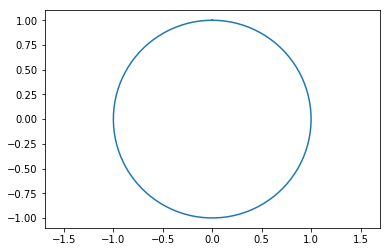

In [14]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

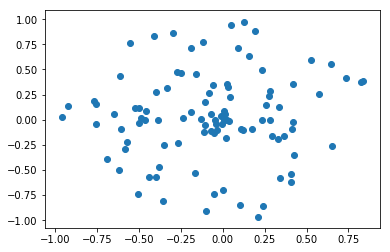

In [15]:
X = np.array([2 * math.pi * rng() for i in range(100)])
Y = np.array([rng() for i in range(100)])

def f(x,y):
    return [math.cos(x)*y, math.sin(x)*y]

A = np.array([f(X[i], Y[i]) for i in range(100)])

plt.scatter(A[:,0], A[:,1])
plt.show()

## Random normal generator

### Exercise
Check theoretically and numerically that the following algorithm (also called Box-Muller algorithm) generates pairs of independent N(0,1) variables. Modify it to exclude ```np.sin``` and ```np.cos``` calls.

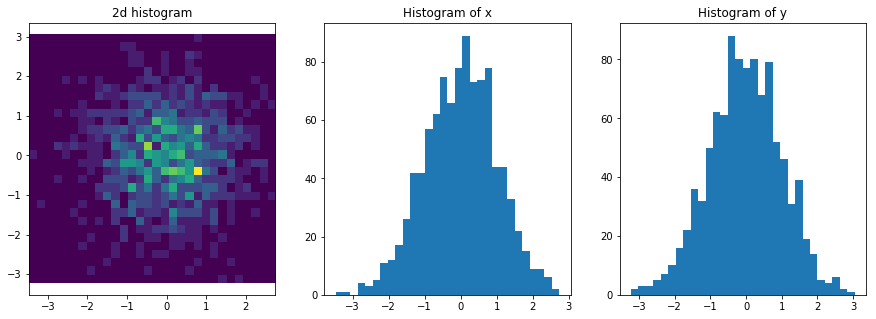

In [18]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

#### Доказательство.
Пусть $(\Omega, F, P)$ - вероятностное пространство, $U_{1} \backsim U(0,1)$, $U_{2} \backsim U(0,1)$ - независимые случайные величины на нём. Рассмотрим $\xi_{1} = \cos(2\pi U_{1})\sqrt{-2lnU_{2}}$, $\xi_{2} = \sin(2\pi U_{1})\sqrt{-2lnU_{2}}$.Заметим, что $\xi_{1}^{2} + \xi_{2}^{2} = -2lnU_{2}$ имеет экспоненциальное распределение с параметром $1/2$, что эквивалентно распределению хи-квадрат с двумя степенями свободы. Рассмотрим случайный вектор, в полярных координатах имеющий вид $(2\pi U_{1}, \sqrt{-2lnU_{2}} )$. Можно проверить, что его плотность есть плотность двумерного гауссовского вектора, что следует из того, что квадрат полярного радиуса распределён экспоненциально (хи-квадрат), а полярный угол - равномерно. Значит, это гауссовский вектор, а $\xi_{1}$ и $\xi_{2}$ - его координаты в декартовой системе, имеющие, соответственно, распределение $N(0,1)$.

Чтобы модифицировать данный метод берём независимые случайные величины $X$ и $Y$, распределённые равномерно на отрезке $[-1,1]$. Если $S:=X^{2}+Y^{2} \leq 1$ положим $\xi_{1} = \sqrt{-2lnS}\frac{X}{\sqrt{S}}$, $\xi_{2} = \sqrt{-2lnS}\frac{Y}{\sqrt{S}}$. В силу предыдущих рассуждений вновь получатся величины, имеющие стандартное нормальное распределение ($\frac{X}{\sqrt{S}}$ и $\frac{Y}{\sqrt{S}}$ - косинус и синус некоторого угла). Данный метод вычисляет меньшее число трансцендентных функций, поэтому он более эффективен.

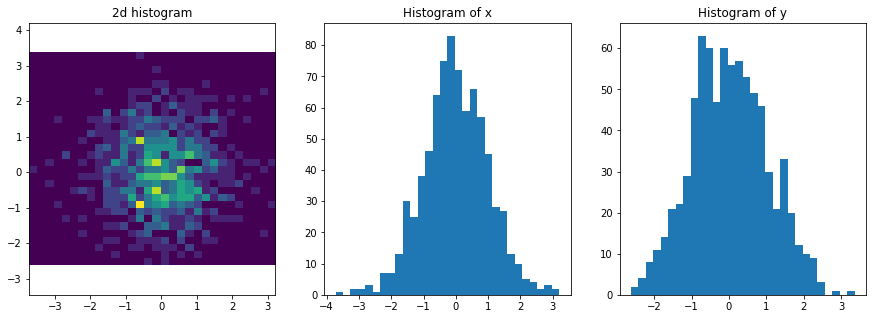

In [23]:
u1, u2 = np.random.rand(2, n) * 2 - 1
s = u1 * u1 + u2 * u2
cos = u1 / np.sqrt(s)
sin = u2 / np.sqrt(s)
mask = s <= 1
x = np.sqrt(-2 * np.log(s[mask])) * cos[mask] 
y = np.sqrt(-2 * np.log(s[mask])) * sin[mask]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

## Markov Chain Monte Carlo (MCMC)

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа (черные вершины имеют значение 1, белые - 0):

![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg)

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\xi - \text{допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$\begin{equation*}
{\rm E} n(\xi) = \sum_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum_{x \in \{0,1\}^V} n(x) {\rm I}_{\{\xi - \text{допустимая} \}}
\end{equation*}$$

Явно перебирать все $x \in \{0,1\}^{V}$ сложновато. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чисел:
$$\begin{equation*}
{\rm E} n(\xi) \approx \frac{1}{N} \sum_{i=1}^{N} n(\xi), \text{где } \xi \sim \mu
\end{equation*}$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

### Метод MCMC

Предназначение: приближенное моделирование случаных величин из заданного распредедения 

Идея:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Вот как это работает https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,multimodal

Алгоритм:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$
* пусть $Q = (q_{i,j})$ - матрица переходных вероятностей произвольной цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_j q_{j,i}}{\pi_i q_{i,j}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

Обоснование и доказательства можно почитать здесь http://probability.ca/jeff/ftpdir/johannes.pdf

Некоторые типичные способы задания $q$:
* Metropolis algorithm: $q_{i,j} = q_{j,i}$
* Random walk Metropolis-Hastings: $q_{i,j} = q(j - i)$
* Independence sampler: $q_{i,j} = q(j)$ independent of $i$

### Задание
1) Описать применение МСМС к задаче оценки  ${\rm E} n(\xi)$, доказать все попутные утверждения

2) Оценить  ${\rm E} n(\xi)$ с помощью МСМС

3) Построить график распределеиня $n(\xi)$

4) Реализовать генератор случайных графов с допустимыми конфигурациями.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray.
        Mask for vertices colors.
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.full_like(narr, 'red', dtype='U5')
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

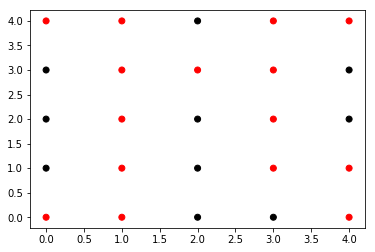

In [17]:
size = 5
narr = np.random.choice([True, False], size=(size, size))
plot_grid(narr)

#### Описание метода
Заводим три переменные, $S1$ чтобы считать количество закрашенных вершин на каждом шаге, $S$ чтобы суммировать $S1$, полученные на каждом шаге и $N$ чтобы считать количество итераций.
На каждом шаге:

1) Случайно выберем вершину графа

2) Принимаем решение о том закрашивать или убирать закраску с помощью случайной величины $X$ из распределения Бернулли с параметром $1/2$ . Если нет соседних закрашенных вершин и $X=1$, то закрашиваем. Если $X=0$ то убираем краску.

3) Если закрасили незакрашенную вершину прибавляем единицу к $S1$. Если стёрли закрашенную, то отнимаем единицу. Прибавляем $S1$ к $S$

Таким образом на каждом шаге мы получили допустимую конфигурацию, и любая конфигурация может быть получена.
Получившаяся марковская цепь имеет стационарное распределение.
Чтобы найти ${\rm E} n(\xi)$ в конце вычислим $S/N$. По ЗБЧ это искомое мат. ожидание.

#### Теорема. 
Данное моделирование распределения $\mu$ корректно

#### Доказательство.
Получившаяся марковская цель неприводима, поскольку из допустимой конфигурации $\xi$ можно получить нулевую конфигурацию за конечное число шагов, в то же время, из нулевой конфигурации за конечное число шагов получается произвольная допустимая конфигурация $\xi'$. Кроме того, данная марковская цепь апериодична, поскольку из $\xi$ можно получить $\xi$ за один шаг. Соответственно, осталось показать, что распределение $\mu_{G}$ обратимо. 

$\mu_{G}(\xi)P_{\xi,\xi'} = \mu_{G}(\xi')P_{\xi',\xi}$

Достаточно доказать для случая, когда $\xi$ и $\xi'$ различаются только в одной вершине, поскольку в случае совпадающих конфигураций равенство, очевидно, справедливо, а в случае различия более, чем в одной вершине, оно следует из того, что один шаг меняет не более, чем одну вершину. Пусть конфигурации различаются ровно в одной вершине. Тогда все её соседи равны 0, поскольку конфигурации допустимые. Но в таком случае обе части равенства просто равны $\frac{1}{2Z_{G}|V|}$. Таким образом, распределение обратимо. Из этого следует, что $\mu_{G}$ стационарно для данной марковской цепи

Input matrix size: 10
Expectation:  20.911
Random config: 


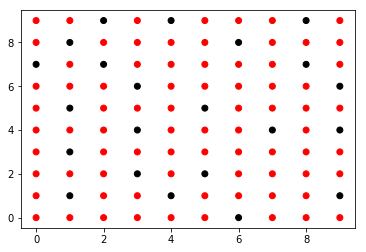

In [20]:

size = int(input("Input matrix size: "))
A = np.array([[False for i in range(size)] for j in range(size)])
S1 = 0
S = 0
N = 0
for i in range(1000):
    t = 1
    v = [np.random.choice(size), np.random.choice(size)]
    X = np.random.choice(2)
    if (v[0] > 0):
        if (v[0] < size - 1):
            if (v[1] > 0):
                if (v[1] < size - 1):
                    if (A[v[0]-1][v[1]] == True):
                        t = 0
                    if (A[v[0]][v[1]+1] == True):
                        t = 0
                    if (A[v[0]][v[1]-1] == True):
                        t = 0
                    if (A[v[0]+1][v[1]] == True):
                        t = 0
                else:
                    if (A[v[0]-1][v[1]] == True):
                        t = 0
                    if (A[v[0]][v[1]-1] == True):
                        t = 0
                    if (A[v[0]+1][v[1]] == True):
                        t = 0
            else:
                if (A[v[0]-1][v[1]] == True):
                    t = 0
                if (A[v[0]][v[1]+1] == True):
                    t = 0
                if (A[v[0]+1][v[1]] == True):
                    t = 0
        else: 
            if (v[1] > 0):
                if (v[1] < size - 1):
                    if (A[v[0]-1][v[1]] == True):
                        t = 0
                    if (A[v[0]][v[1]-1] == True):
                        t = 0
                    if (A[v[0]][v[1]+1] == True):
                        t = 0
                else:
                    if (A[v[0]-1][v[1]] == True):
                        t = 0
                    if (A[v[0]][v[1]-1] == True):
                        t = 0
            else:
                if (A[v[0]-1][v[1]] == True):
                    t = False
                if (A[v[0]][v[1]+1] == True):
                    t = False
    else:
        if (v[1] > 0):
            if (v[1] < size - 1):
                if (A[v[0]][v[1]-1] == True):
                    t = 0
                if (A[v[0]][v[1]+1] == True):
                    t = 0
                if (A[v[0]+1][v[1]] == True):
                    t = 0         
            else:
                if (A[v[0]][v[1]-1] == True):
                    t = 0
                if (A[v[0]+1][v[1]] == True):
                    t = 0
        else:
            if (A[v[0]][v[1]+1] == True):
                t = 0
            if (A[v[0]+1][v[1]] == True):
                t = 0
    if (X == 1 and t == 1):
        if (A[v[0]][v[1]] == False):
            S1 += 1
        A[v[0]][v[1]] = True
    else:
        if (A[v[0]][v[1]] == True):
            S1 -= 1
        A[v[0]][v[1]] = False
    S += S1
    N += 1

print("Expectation: ", S / N)
print("Random config: ")
plot_grid(A)

### Submit to https://goo.gl/forms/aszSXdC53VV19kwx2